Uploading Kaggle file and loading the dataset (Dogs vs Cats)

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krupakrishna","key":"e6f61c0b3890d71e95ae39840b4c829c"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

100% 811M/812M [00:36<00:00, 24.5MB/s]
100% 812M/812M [00:36<00:00, 23.2MB/s]


### Q1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

Creating subsets from dataset to train, validation and test directory

In [4]:
import os, shutil, pathlib
original_directory = pathlib.Path("train")
new_base_directory = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_directory / subset_name / category
        os.makedirs(dir, exist_ok=True)

        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_directory / fname
            dst = dir / fname
            shutil.copyfile(src, dst)

make_subset("train", start_index= 100, end_index=1100)
make_subset("validation", start_index=1101, end_index=1601)
make_subset("test", start_index=1602, end_index=2102)

Using CNN to build a basic model that classifies dogs from cats

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
training_set = image_dataset_from_directory(
new_base_directory / "train",
image_size=(180, 180),
batch_size=32)
validation_set = image_dataset_from_directory(
new_base_directory / "validation",
image_size=(180, 180),
batch_size=32)
test_set= image_dataset_from_directory(
new_base_directory / "test",
image_size=(180, 180),
batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Generating an instance of the dataset with a vector size of 16 and 1000 random samples using a NumPy array

In [6]:
import numpy as nump
import tensorflow as tensf
random_num = nump.random.normal(size=(1000, 16))
set = tensf.data.Dataset.from_tensor_slices(random_num)
for i, element in enumerate(set):
    print(element.shape)
    if i >= 2:
       break

batch_set = set.batch(32)
for i, element in enumerate(batch_set):
    print(element.shape)
    if i >= 2:
       break

reshape_set = set.map(lambda x: tensf.reshape(x, (4, 4)))
for i, element in enumerate(reshape_set):
    print(element.shape)
    if i >= 2:
       break

(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)


Showing the data shapes and the labels

In [7]:
for data_batch, labels_batch in training_set:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Identifying convolution for Dogs vs Cats dataset

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
inputset_1000 = keras.Input(shape=(180, 180, 3))
din = layers.Rescaling(1./255)(inputset_1000)
din = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(din)
din = layers.MaxPooling2D(pool_size=2)(din)
din = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(din)
din = layers.MaxPooling2D(pool_size=2)(din)
din = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(din)
din = layers.MaxPooling2D(pool_size=2)(din)
din = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(din)
din = layers.MaxPooling2D(pool_size=2)(din)
din = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(din)
din = layers.Flatten()(din)
din = layers.Dropout(0.5)(din)
outputset_1000 = layers.Dense(1, activation="sigmoid")(din)
model_1 = keras.Model(inputs=inputset_1000, outputs=outputset_1000)

Training the model

In [9]:
model_1.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"])

In [10]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

Fitting the model

In [11]:
call_backs1000 = [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch.keras",
save_best_only=True,
monitor="val_loss")
]
hist1000 = model_1.fit(training_set,
epochs=100,
validation_data=validation_set,
callbacks=call_backs1000)

Epoch 1/100
63/63 [==============================] - 16s 109ms/step - loss: 0.6947 - accuracy: 0.4915 - val_loss: 0.6891 - val_accuracy: 0.5040
Epoch 2/100
63/63 [==============================] - 4s 62ms/step - loss: 0.6881 - accuracy: 0.5335 - val_loss: 0.6934 - val_accuracy: 0.5010
Epoch 3/100
63/63 [==============================] - 6s 85ms/step - loss: 0.6827 - accuracy: 0.5475 - val_loss: 0.6857 - val_accuracy: 0.5950
Epoch 4/100
63/63 [==============================] - 7s 96ms/step - loss: 0.6636 - accuracy: 0.6055 - val_loss: 0.6527 - val_accuracy: 0.6260
Epoch 5/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6285 - accuracy: 0.6580 - val_loss: 0.6228 - val_accuracy: 0.6550
Epoch 6/100
63/63 [==============================] - 4s 63ms/step - loss: 0.6119 - accuracy: 0.6695 - val_loss: 0.6028 - val_accuracy: 0.6720
Epoch 7/100
63/63 [==============================] - 8s 119ms/step - loss: 0.5943 - accuracy: 0.6760 - val_loss: 0.6007 - val_accuracy: 0.6860
Epo

Plotting the accuracy and loss for training dataset

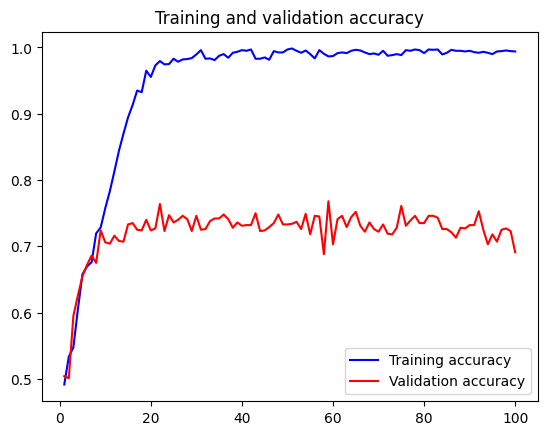

<Figure size 640x480 with 0 Axes>

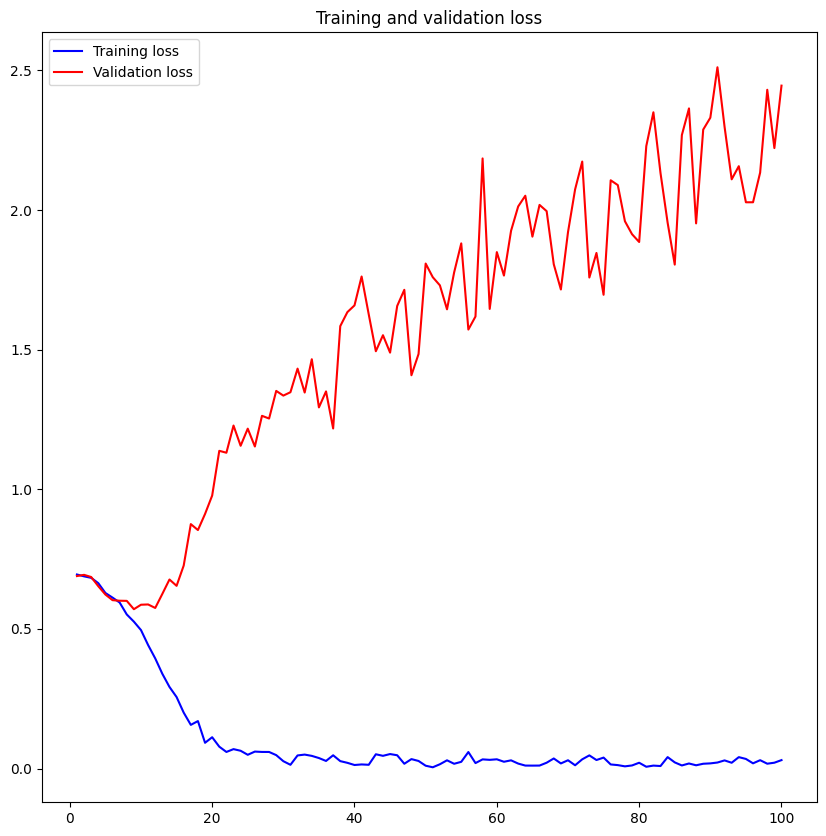

In [12]:
import matplotlib.pyplot as plt
acc = hist1000.history["accuracy"]
valid_accuracy = hist1000.history["val_accuracy"]
loss = hist1000.history["loss"]
validation_loss = hist1000.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "b", label="Training accuracy")
plt.plot(epochs, valid_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, validation_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Accuracy of test set

In [ ]:
test_set1000 = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_accuracy = test_set1000.evaluate(test_set)
print(f"Test accuracy: {test_accuracy:.2f}")

32/32 [==============================] - 2s 31ms/step - loss: 1.7652 - accuracy: 0.7100
Test accuracy: 0.71


### Q2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

To optimize the network, we are using data augmentation

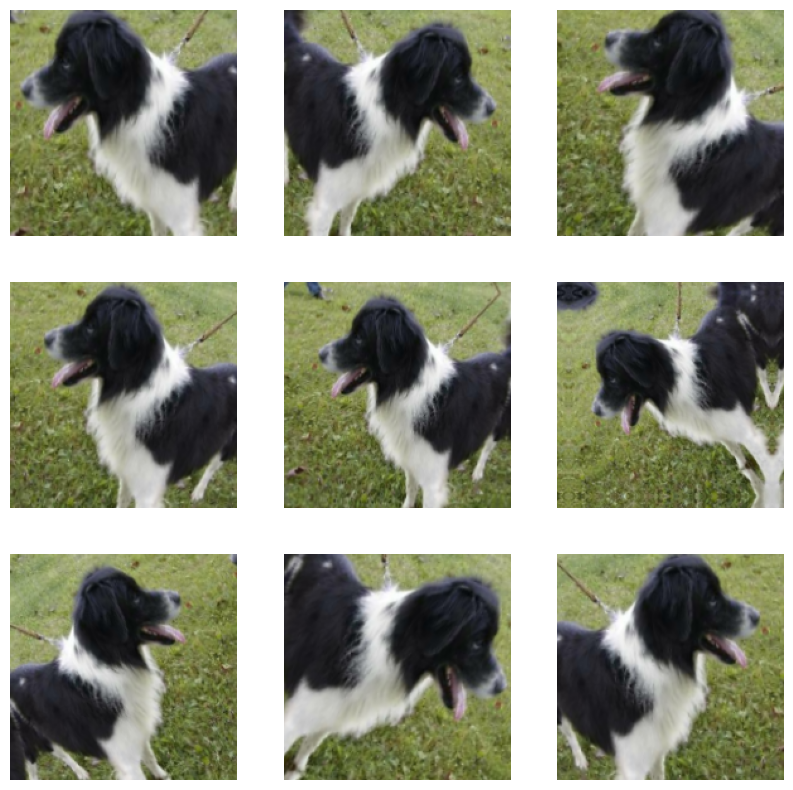

In [13]:
import os, shutil, pathlib
shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)
original_directory = pathlib.Path("train")
new_base_directory = pathlib.Path("cats_vs_dogs_small_Q2")
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_directory / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_directory / fname,
            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=100, end_index=1600)
make_subset("validation", start_index=1601, end_index=2101)
make_subset("test", start_index=2101, end_index=2602)
augmentation_info = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
plt.figure(figsize=(10, 10))
for images, _ in training_set.take(1):
    for i in range(9):
        augmented_images = augmentation_info(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

CNN with augmentation and dropout

In [14]:
input_set = keras.Input(shape=(180, 180, 3))
din_2 = augmentation_info(input_set)
din_2 = layers.Rescaling(1./255)(din_2)
din_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(din_2)
din_2 = layers.MaxPooling2D(pool_size=2)(din_2)
din_2 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(din_2)
din_2 = layers.MaxPooling2D(pool_size=2)(din_2)
din_2 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(din_2)
din_2 = layers.MaxPooling2D(pool_size=2)(din_2)
din_2 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(din_2)
din_2 = layers.MaxPooling2D(pool_size=2)(din_2)
din_2 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(din_2)
din_2 = layers.Flatten()(din_2)
din_2 = layers.Dropout(0.5)(din_2)
output_set = layers.Dense(1, activation="sigmoid")(din_2)
model_2 = keras.Model(inputs=input_set, outputs=output_set)
model_2.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"])
callback_2 = [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch_with_augmentation_info.keras",
save_best_only=True,
monitor="val_loss")
]
hist_2 = model_2.fit(
training_set,
epochs=100,
validation_data=validation_set,
callbacks=callback_2)

Epoch 1/100
63/63 [==============================] - 10s 97ms/step - loss: 0.6967 - accuracy: 0.5200 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 7s 99ms/step - loss: 0.6913 - accuracy: 0.5160 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6921 - accuracy: 0.5085 - val_loss: 0.6880 - val_accuracy: 0.5450
Epoch 4/100
63/63 [==============================] - 7s 107ms/step - loss: 0.6883 - accuracy: 0.5255 - val_loss: 0.6883 - val_accuracy: 0.5490
Epoch 5/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6880 - accuracy: 0.5495 - val_loss: 0.6699 - val_accuracy: 0.5730
Epoch 6/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6867 - accuracy: 0.5570 - val_loss: 0.6798 - val_accuracy: 0.5620
Epoch 7/100
63/63 [==============================] - 6s 87ms/step - loss: 0.6724 - accuracy: 0.6055 - val_loss: 0.6772 - val_accuracy: 0.6100
Epoc

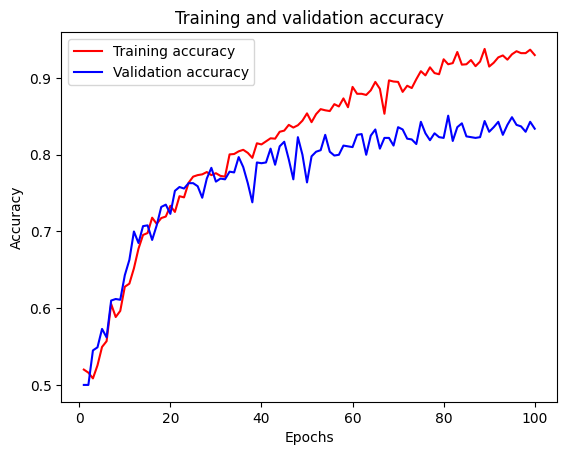

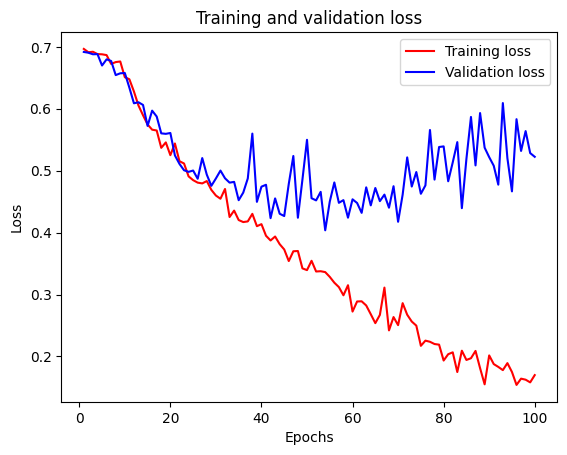

In [16]:
accuracy_2 = hist_2.history["accuracy"]
validacc_2 = hist_2.history["val_accuracy"]
loss_2 = hist_2.history["loss"]
validloss_2 = hist_2.history["val_loss"]
epochs = range(1, len(accuracy_2) + 1)

plt.plot(epochs, accuracy_2, "r", label="Training accuracy")
plt.plot(epochs, validacc_2, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss_2, "r", label="Training loss")
plt.plot(epochs, validloss_2, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Accuracy of test data with augmentation and dropout

In [17]:
test_2 = keras.models.load_model(
"convnet_from_scratch_with_augmentation_info.keras")
test_loss, test_accuracy = test_2.evaluate(test_set)
print(f"Test accuracy: {test_accuracy:.2f}")

32/32 [==============================] - 3s 57ms/step - loss: 0.4303 - accuracy: 0.8030
Test accuracy: 0.80


### Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

Increasing the size of training dataset to 2000 while using the same size for validation and testing (500)

In [18]:
new_base_directory = pathlib.Path("cats_vs_dogs_small_Q3")
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_directory / subset_name / category
        os.makedirs(dir, exist_ok = True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_directory / fname,
            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=100, end_index=2100)
make_subset("validation", start_index=2101, end_index=2601)
make_subset("test", start_index=2602, end_index=3102)
inputs_3 = keras.Input(shape=(180, 180, 3))
din_3 = augmentation_info(inputs_3)
din_3 = layers.Rescaling(1./255)(din_3)
din_3 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(din_3)
din_3 = layers.MaxPooling2D(pool_size=2)(din_3)
din_3 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(din_3)
din_3 = layers.MaxPooling2D(pool_size=2)(din_3)
din_3 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(din_3)
din_3 = layers.MaxPooling2D(pool_size=2)(din_3)
din_3 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(din_3)
din_3 = layers.MaxPooling2D(pool_size=2)(din_3)
din_3 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(din_3)
din_3 = layers.Flatten()(din_3)
din_3 = layers.Dropout(0.5)(din_3)
outputs_3 = layers.Dense(1, activation="sigmoid")(din_3)
model_3 = keras.Model(inputs=inputs_3, outputs=outputs_3)
model_3.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"])
callbacks_3 = [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch_with_augmentation_info.keras",
save_best_only=True,
monitor="val_loss")
]
hist_3 = model_3.fit(
training_set,
epochs=100,
validation_data=validation_set,
callbacks=callbacks_3)


Epoch 1/100
63/63 [==============================] - 10s 105ms/step - loss: 0.6944 - accuracy: 0.5150 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 4s 65ms/step - loss: 0.6944 - accuracy: 0.4900 - val_loss: 0.6928 - val_accuracy: 0.5190
Epoch 3/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6913 - accuracy: 0.5375 - val_loss: 0.6852 - val_accuracy: 0.5470
Epoch 4/100
63/63 [==============================] - 7s 108ms/step - loss: 0.6890 - accuracy: 0.5180 - val_loss: 0.6872 - val_accuracy: 0.5430
Epoch 5/100
63/63 [==============================] - 4s 66ms/step - loss: 0.6857 - accuracy: 0.5325 - val_loss: 0.6778 - val_accuracy: 0.5680
Epoch 6/100
63/63 [==============================] - 6s 95ms/step - loss: 0.6872 - accuracy: 0.5440 - val_loss: 0.6796 - val_accuracy: 0.5470
Epoch 7/100
63/63 [==============================] - 4s 62ms/step - loss: 0.6903 - accuracy: 0.5520 - val_loss: 0.6887 - val_accuracy: 0.5620
Epo

Accuracy of Test model

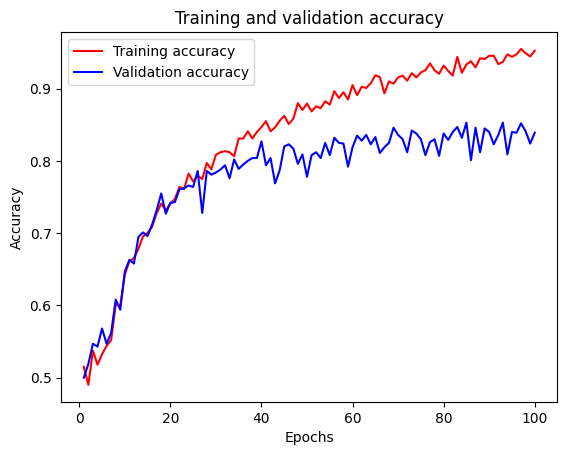

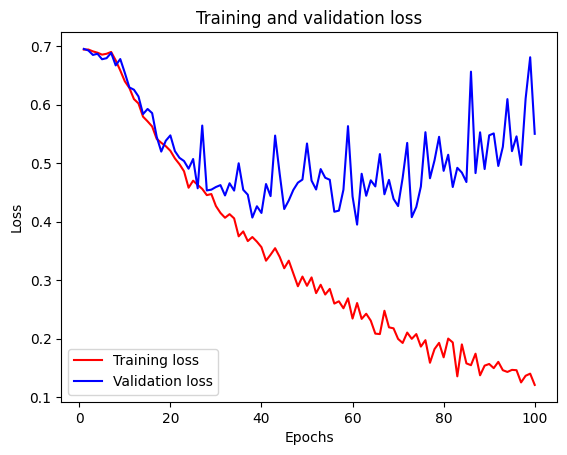

In [21]:
accuracy_3 = hist_3.history["accuracy"]
validacc_3 = hist_3.history["val_accuracy"]
loss_3 = hist_3.history["loss"]
validloss_3 = hist_3.history["val_loss"]
epochs = range(1, len(accuracy_3) + 1)

plt.plot(epochs, accuracy_3, "r", label="Training accuracy")
plt.plot(epochs, validacc_3, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss_3, "r", label="Training loss")
plt.plot(epochs, validloss_3, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
testacc_3 = keras.models.load_model(
"convnet_from_scratch_with_augmentation_info.keras")
test_loss, test_acc = testacc_3.evaluate(test_set)
print(f"Test accuracy: {test_acc:.2f}")

32/32 [==============================] - 3s 59ms/step - loss: 0.4306 - accuracy: 0.8270
Test accuracy: 0.83


### Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

Loading the VGG16 convolution base

In [22]:
convoluted_img = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False,
input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [23]:
convoluted_img.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Pre-training the model for feature extraction without using data augmentation

In [24]:
import numpy as nump
def get_features_and_labels(dataset):
    all_feature = []
    all_label = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convoluted_img.predict(preprocessed_images)
        all_feature.append(features)
        all_label.append(labels)
    return nump.concatenate(all_feature), nump.concatenate(all_label)
train_features, train_labels = get_features_and_labels(training_set)
val_features, val_labels = get_features_and_labels(validation_set)
test_features, test_labels = get_features_and_labels(test_set)

1/1 [==============================] - 0s 22ms/step


In [25]:
train_features.shape

(2000, 5, 5, 512)

CNN with Feature Extraction

In [26]:
inputs_4 = keras.Input(shape=(5, 5, 512))
din_4 = layers.Flatten()(inputs_4)
din_4 = layers.Dense(256)(din_4)
din_4 = layers.Dropout(0.5)(din_4)
output_4 = layers.Dense(1, activation="sigmoid")(din_4)
model_4 = keras.Model(inputs_4, output_4)
model_4.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])
callbacks_4 = [
keras.callbacks.ModelCheckpoint(
filepath="feature_extraction.keras",
save_best_only=True,
monitor="val_loss")
]
hist_4 = model_4.fit(
train_features, train_labels,
epochs=100,
validation_data=(val_features, val_labels),
callbacks=callbacks_4)

Epoch 1/100
63/63 [==============================] - 1s 11ms/step - loss: 17.2912 - accuracy: 0.9220 - val_loss: 3.3107 - val_accuracy: 0.9730
Epoch 2/100
63/63 [==============================] - 0s 7ms/step - loss: 3.1903 - accuracy: 0.9770 - val_loss: 3.9698 - val_accuracy: 0.9740
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 1.4484 - accuracy: 0.9870 - val_loss: 5.8239 - val_accuracy: 0.9670
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 1.6793 - accuracy: 0.9860 - val_loss: 4.3063 - val_accuracy: 0.9740
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 0.7027 - accuracy: 0.9930 - val_loss: 4.3823 - val_accuracy: 0.9760
Epoch 6/100
63/63 [==============================] - 0s 7ms/step - loss: 1.0497 - accuracy: 0.9915 - val_loss: 4.5363 - val_accuracy: 0.9700
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 0.4386 - accuracy: 0.9965 - val_loss: 5.1680 - val_accuracy: 0.9800
Epoch 8/100

Plotting the accuracy of training and validation set

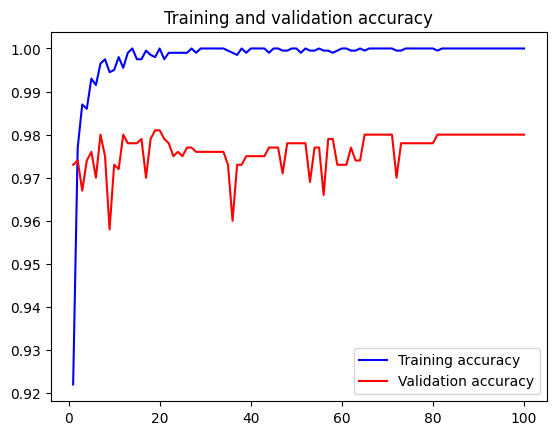

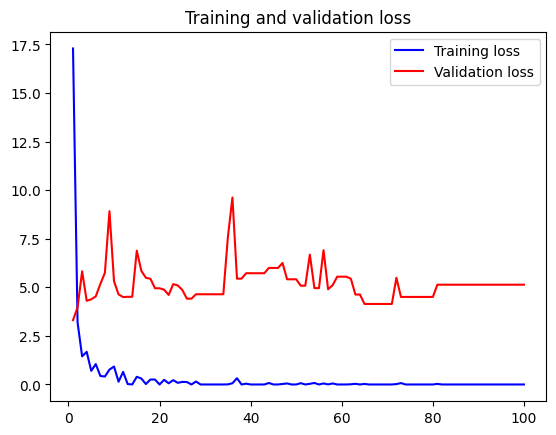

In [27]:
import matplotlib.pyplot as plt
accuracy_4 = hist_4.history["accuracy"]
valid_acc_4 = hist_4.history["val_accuracy"]
loss_4 = hist_4.history["loss"]
validationloss_4 = hist_4.history["val_loss"]
epochs = range(1, len(accuracy_4) + 1)
plt.plot(epochs, accuracy_4, "b", label="Training accuracy")
plt.plot(epochs, valid_acc_4, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss_4, "b", label="Training loss")
plt.plot(epochs, validationloss_4, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [28]:
convoluted_img = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False)
convoluted_img.trainable = False
convoluted_img.trainable = True
print("This is the number of trainable weights "
"before freezing the conv base:", len(convoluted_img.trainable_weights))
convoluted_img.trainable = False
print("This is the number of trainable weights "
"after freezing the conv base:", len(convoluted_img.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Model is now performing with a classifier and agumentation to convulation base

In [29]:
augmented_2 = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
inputs_5 = keras.Input(shape=(180, 180, 3))
din_5 = augmented_2(inputs_5)
din_5 =keras.layers.Lambda(
lambda x: keras.applications.vgg16.preprocess_input(x))(din_5)
din_5 = convoluted_img(din_5)
din_5 = layers.Flatten()(din_5)
din_5 = layers.Dense(256)(din_5)
din_5 = layers.Dropout(0.5)(din_5)
output_5 = layers.Dense(1, activation="sigmoid")(din_5)
model_5 = keras.Model(inputs_5, output_5)
model_5.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])
callbacks_5 = [
keras.callbacks.ModelCheckpoint(
filepath="features_extraction_with_augmentation2.keras",
save_best_only=True,
monitor="val_loss"
)
]
hist_5 = model_5.fit(
training_set,
epochs=100,
validation_data=validation_set,
callbacks= callbacks_5
)


Epoch 1/100
63/63 [==============================] - 12s 170ms/step - loss: 15.1173 - accuracy: 0.8980 - val_loss: 4.6135 - val_accuracy: 0.9730
Epoch 2/100
63/63 [==============================] - 10s 153ms/step - loss: 7.1031 - accuracy: 0.9420 - val_loss: 9.0996 - val_accuracy: 0.9610
Epoch 3/100
63/63 [==============================] - 12s 180ms/step - loss: 5.8485 - accuracy: 0.9530 - val_loss: 6.7948 - val_accuracy: 0.9680
Epoch 4/100
63/63 [==============================] - 10s 161ms/step - loss: 5.6480 - accuracy: 0.9625 - val_loss: 2.7101 - val_accuracy: 0.9800
Epoch 5/100
63/63 [==============================] - 9s 146ms/step - loss: 4.8035 - accuracy: 0.9565 - val_loss: 8.1870 - val_accuracy: 0.9600
Epoch 6/100
63/63 [==============================] - 11s 165ms/step - loss: 2.8589 - accuracy: 0.9715 - val_loss: 2.2860 - val_accuracy: 0.9740
Epoch 7/100
63/63 [==============================] - 10s 148ms/step - loss: 4.3305 - accuracy: 0.9670 - val_loss: 3.1342 - val_accuracy:

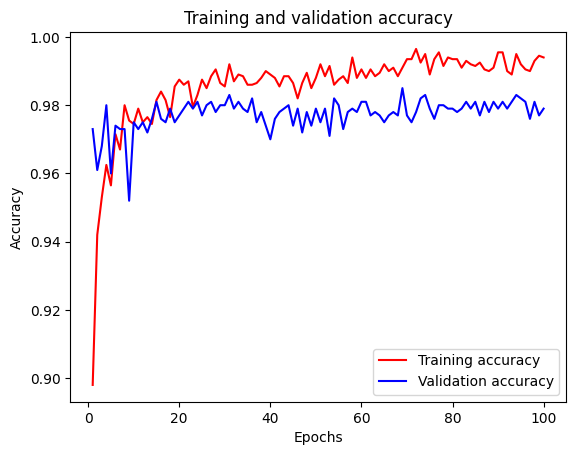

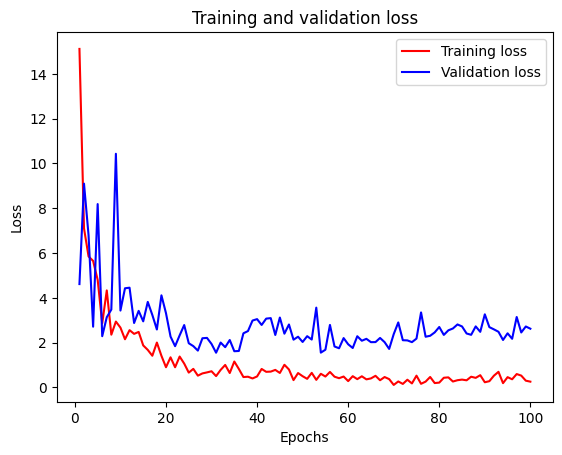

In [32]:
accuracy_an = hist_5.history["accuracy"]
validacc_an = hist_5.history["val_accuracy"]
loss_an = hist_5.history["loss"]
validloss_an = hist_5.history["val_loss"]
epochs = range(1, len(accuracy_an) + 1)

plt.plot(epochs, accuracy_an, "r", label="Training accuracy")
plt.plot(epochs, validacc_an, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss_an, "r", label="Training loss")
plt.plot(epochs, validloss_an, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Accuracy of test model

In [33]:
testacc_5 = keras.models.load_model(
"features_extraction_with_augmentation2.keras",safe_mode=False)
test_loss, test_acc = testacc_5.evaluate(test_set)
print(f"Test accuracy: {test_acc:.2f}")

32/32 [==============================] - 4s 94ms/step - loss: 1.6978 - accuracy: 0.9790
Test accuracy: 0.98


Fine-tuning the model

In [34]:
convoluted_img.trainable = True
for layer in convoluted_img.layers[:-4]:
    layer.trainable = False

model_5.compile(loss="binary_crossentropy",
optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
metrics=["accuracy"])
callbacks_tuning = [
keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]
hist_tuning = model_5.fit(
training_set,
epochs=100 ,
validation_data=validation_set,
callbacks=callbacks_tuning)

Epoch 1/100
63/63 [==============================] - 15s 195ms/step - loss: 0.3211 - accuracy: 0.9895 - val_loss: 2.8451 - val_accuracy: 0.9750
Epoch 2/100
63/63 [==============================] - 13s 207ms/step - loss: 0.2561 - accuracy: 0.9930 - val_loss: 2.6983 - val_accuracy: 0.9790
Epoch 3/100
63/63 [==============================] - 12s 182ms/step - loss: 0.1800 - accuracy: 0.9945 - val_loss: 2.2230 - val_accuracy: 0.9810
Epoch 4/100
63/63 [==============================] - 11s 168ms/step - loss: 0.3109 - accuracy: 0.9920 - val_loss: 2.2591 - val_accuracy: 0.9810
Epoch 5/100
63/63 [==============================] - 12s 183ms/step - loss: 0.4598 - accuracy: 0.9910 - val_loss: 1.9743 - val_accuracy: 0.9810
Epoch 6/100
63/63 [==============================] - 11s 166ms/step - loss: 0.0402 - accuracy: 0.9975 - val_loss: 1.9820 - val_accuracy: 0.9800
Epoch 7/100
63/63 [==============================] - 11s 175ms/step - loss: 0.2168 - accuracy: 0.9935 - val_loss: 3.1265 - val_accuracy:

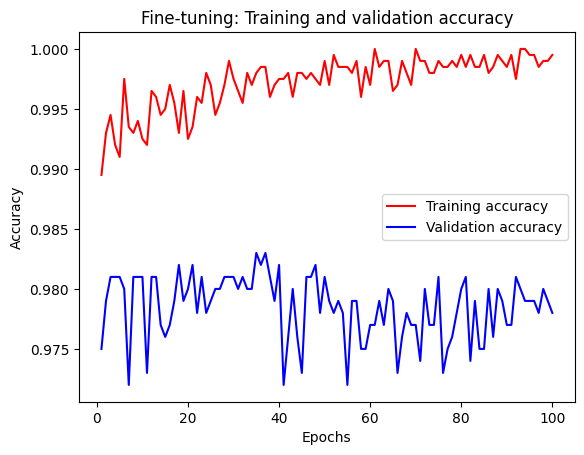

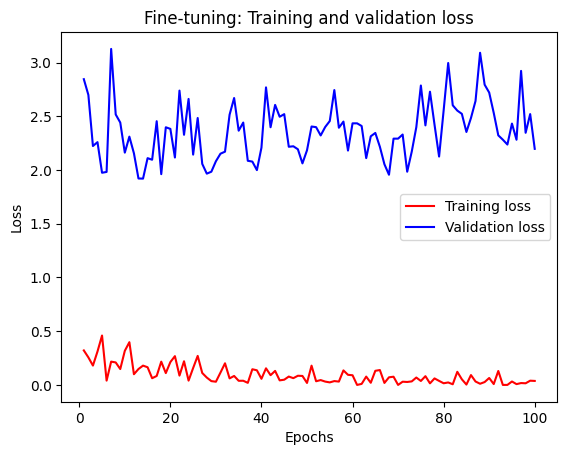

In [36]:
acc_tuning = hist_tuning.history["accuracy"]
valid_tuning = hist_tuning.history["val_accuracy"]
loss_tuning = hist_tuning.history["loss"]
valid_loss_tuning = hist_tuning.history["val_loss"]
epochs = range(1, len(acc_tuning) + 1)

plt.plot(epochs, acc_tuning, "r", label="Training accuracy")
plt.plot(epochs, valid_tuning, "b", label="Validation accuracy")
plt.title("Fine-tuning: Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss_tuning, "r", label="Training loss")
plt.plot(epochs, valid_loss_tuning, "b", label="Validation loss")
plt.title("Fine-tuning: Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Accuracy of test set

In [37]:
testacc_5 = keras.models.load_model(
"fine_tuning.keras",safe_mode=False)
test_loss, test_acc = testacc_5.evaluate(test_set)
print(f"Test accuracy: {test_acc:.2f}")

32/32 [==============================] - 4s 90ms/step - loss: 1.5335 - accuracy: 0.9780
Test accuracy: 0.98
